# **A/B testing**

## **Business hypothesis**
**Null**: CTR of 'Learn More' button with blue color is equal to CTR of green button.

**Alternate** : CTR of 'Learn More' button with green color is not equal to CTR of the blue button.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
exp_data = data[data['group'] == 'exp']

In [4]:
con_data = data[data['group'] == 'con']

## **Visualize the data**

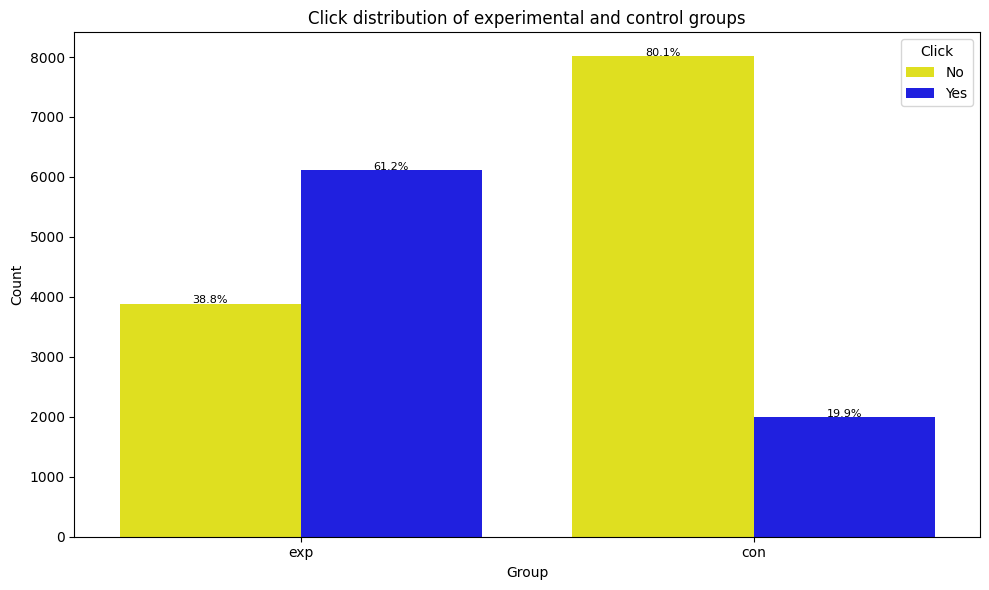

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='group',hue='click',data=data,palette={0:'yellow',1:'blue'})
plt.title("Click distribution of experimental and control groups")
plt.xlabel("Group")
plt.ylabel("Count")
plt.legend(title='Click' ,labels=['No',"Yes"])

#Add the percentage labels
group_count = data.groupby('group').size()
group_click_count = data.groupby(['group','click'])

#Get the axes
ax= plt.gca()

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x,y = p.get_xy()
    group = 'exp' if x<0.5 else 'con'
    click = 1 if x % 1 > 0.5 else 0
    total = group_count.loc[group]
    percentage = height/total * 100
    if height>0:
      ax.text(x+width/2, height+6, f'{percentage:.1f}%',ha='center',size=8)

plt.tight_layout()
    

### **Statistical Hypothesis**
$H_0: p_{con} = p_{exp}
$

$
H_1: p_{con} \neq p_{exp}
$

### **Parameters of the model**

 * &beta; : Probability of **Type-II error**
 * 1-&beta; : **Power** of the test
 * &alpha; : Probability of **Type-I error** or level of significance
 * &delta; : Minimum Detectable effect (**MDE**)

In [6]:
alpha = 0.05
delta = 0.1

Since our primary metric is in the form of proportion, we are using the 2 sample Z-test

## **Calculating pooled estimates**

#### **Control Group Click Probability**:
$\hat{p}_{con} = \frac{X_{con}}{N_{con}}$ = $\frac{\#clicks_{con}}{\#impressions_{con}}$


#### **Experiment Group Click Probability**:
$\hat{p}_{exp} = \frac{X_{exp}}{N_{exp}} = \frac{\#clicks_{exp}}{\#impressions_{exp}}$

#### **Pooled Click Probability:**
$\hat{p}_{pooled}$ = $\frac{X_{con} + X_{exp}}{N_{con} + N_{exp}}$ = $\frac{\#clicks_{con} + \#clicks_{exp}}{\#impressions_{con} + \#impressions_{exp}}$

#### **Variance of Pooled Click Probability:**
$\hat{S}^2_{pooled} = \hat{p}_{pooled} \cdot (1 - \hat{p}_{pooled}) \cdot \left( \frac{1}{N_{con}} + \frac{1}{N_{exp}} \right)
$


In [7]:
X_con= con_data[con_data['click'] == 1].count().loc['click']
N_con = con_data.count().loc['user_id']

In [8]:
X_exp = exp_data[exp_data['click']==1].count().loc['click']
N_exp = exp_data.count().loc['user_id']

In [9]:
p_con = X_con/N_con

In [10]:
p_exp = X_exp / N_exp

In [11]:
p_pooled = (X_con + X_exp)/(N_con + N_exp)

In [12]:
pooled_variance = p_pooled * (1-p_pooled) * (1/N_con + 1/N_exp)

### **Calculating standard error of estimate**
SE = $\sqrt{\hat{S}^2_{pooled}}$


In [13]:
SE = np.sqrt(pooled_variance)

 ### **Calculating test statistics**

$T = \frac{\hat{p}_{con} - \hat{p}_{exp}}{\sqrt{\hat{S}^2_{pooled}}}$
 

In [14]:
T = (p_con - p_exp)/SE

### **Calculating crtical value of Z**

In [15]:
Z_critical = norm.ppf(1-alpha/2)

### **Calculating p-value**

$ p_{value} = Pr[{Z<= -T} or {Z >= T}]   = 2 * Pr[Z>= T] $

In [16]:
p_value = 2 * norm.sf(abs(T))

### **Statistical Significance**

In [17]:
if p_value <= alpha:
    print("There is statistical significance, indicating that the observed differences between the groups are unlikely to occur by random chance")
else:
    print("There is no statistical significance, indicating that the observed differences between the groups are likely to occur by chance")

There is statistical significance, indicating that the observed differences between the groups are unlikely to occur by random chance


### **Calcualting Confidence Interval**

$CI = (\hat{p}_{con} - \hat{p}_{exp)} - Z * SE,(\hat{p}_{con} - \hat{p}_{exp}) + Z * SE $

In [18]:
#Creating a standard normal distribution
mu = 0
sigma = 1
x = np.linspace(mu-3*sigma, mu + 3*sigma , 100)
y = norm.pdf(x,mu,sigma)

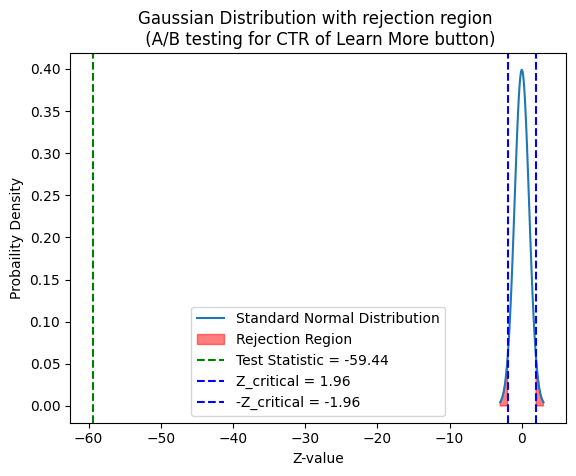

In [19]:
plt.plot(x,y ,label='Standard Normal Distribution')
plt.fill_between(x,y,where=(x>Z_critical) | (x<-Z_critical),alpha = 0.5,label='Rejection Region',color='red')
plt.axvline(T,color='green',linestyle='dashed' ,label=f'Test Statistic = {T:.2f}')
plt.axvline(Z_critical,color='blue',linestyle='dashed' ,label=f'Z_critical = {Z_critical:.2f}')
plt.axvline(-Z_critical,color='blue',linestyle='dashed' ,label=f'-Z_critical = {-Z_critical:.2f}')
plt.xlabel("Z-value")
plt.ylabel("Probaility Density")
plt.legend()
plt.title("Gaussian Distribution with rejection region \n (A/B testing for CTR of Learn More button)")
plt.show()

In [20]:
CI = [
    round((p_exp - p_con) - SE * Z_critical,3),
    round((p_exp - p_con) + SE * Z_critical,3)
]

In [21]:
print(f"The confidence interval of 2 sample z-test: {CI[0]} - {CI[1]}")

The confidence interval of 2 sample z-test: 0.399 - 0.426


## **Practical Significance**

In [22]:
lower_bound = CI[0]
lower_bound

np.float64(0.399)

In [23]:
if lower_bound >= delta:
    print("The difference between Control and Experimental goup is practically significant")
else:
    print("The difference between Control and Experimental goup is not practically significant")
    

The difference between Control and Experimental goup is practically significant


Therefore, we conclude that the green button significantly outperforms the blue button in terms of CTR, and this difference is both statistically and practically significant.